In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mhskii","key":"9d67a7721b6e1c2dc98c81c3420c05bd"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!ls

100% 2.29G/2.29G [00:20<00:00, 130MB/s]
100% 2.29G/2.29G [00:20<00:00, 119MB/s]
chest-xray-pneumonia.zip  kaggle.json  sample_data


In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
!mkdir dataset

In [ ]:
!unzip /content/chest-xray-pneumonia.zip -d dataset

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0445-0001.jpeg  


In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import *
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from keras.preprocessing.image import array_to_img, img_to_array
import os

In [ ]:
train_dir = '/content/dataset/chest_xray/train'
valid_dir = '/content/dataset/chest_xray/val'
test_dir = '/content/dataset/chest_xray/test'

In [ ]:
train_normal = os.path.join(train_dir, 'NORMAL')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA')

valid_normal = os.path.join(valid_dir, 'NORMAL')
valid_pneumonia = os.path.join(valid_dir, "PNEUMONIA")

test_normal = os.path.join(test_dir, "NORMAL")
test_pneumonia = os.path.join(test_dir, 'PNEUMONIA')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    vertical_flip = True,
    zoom_range = 0.3)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    class_mode = 'binary',
    batch_size = 32,
    target_size = (256, 256)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    class_mode = 'binary',
    batch_size = 32,
    target_size = (256, 256)
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


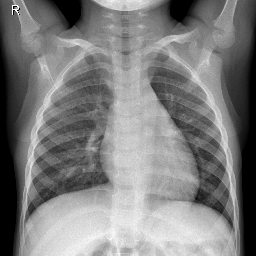

In [ ]:
load_img(os.path.join(train_normal, os.listdir(train_normal)[1]), target_size= (256, 256, 3))

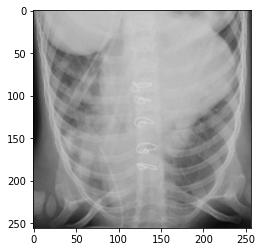

In [ ]:
plt.imshow(train_generator[0][0][0])

In [ ]:
from keras import regularizers

model = Sequential()

model.add(Conv2D(16, (3,3), activation= 'relu', padding = 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding = 'same'))
model.add(MaxPool2D((2,2)))

model.add(SeparableConv2D(
    64,
    (3, 3), 
    activation = 'relu', 
    padding = 'same', 
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))

model.add(SeparableConv2D(
    64,
    (3, 3),
    activation = 'relu',
    padding = 'same',
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(SeparableConv2D(
    128,
    (3, 3), 
    activation = 'relu', 
    padding = 'same', 
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))

model.add(SeparableConv2D(
    128,
    (3, 3),
    activation = 'relu',
    padding = 'same',
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))
model.add(MaxPool2D((2,2)))

model.add(Flatten())


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

# import keras


callbacks = [    
    keras.callbacks.ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
]

model.compile(
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_generator,
    epochs = 20,
    batch_size = 16,
    validation_data = test_generator,
    callbacks = callbacks
)

Epoch 1/20
163/163 [==============================] - 1105s 7s/step - loss: 0.5943 - accuracy: 0.7357 - val_loss: 1.2084 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 1114s 7s/step - loss: 0.3098 - accuracy: 0.8616 - val_loss: 0.4902 - val_accuracy: 0.8045
Epoch 3/20
163/163 [==============================] - 1122s 7s/step - loss: 0.2824 - accuracy: 0.8742 - val_loss: 0.4485 - val_accuracy: 0.7885
Epoch 4/20
163/163 [==============================] - 1105s 7s/step - loss: 0.2417 - accuracy: 0.9028 - val_loss: 0.9759 - val_accuracy: 0.7115
Epoch 5/20
163/163 [==============================] - 1120s 7s/step - loss: 0.2301 - accuracy: 0.9003 - val_loss: 0.6837 - val_accuracy: 0.5897
Epoch 6/20
163/163 [==============================] - 1141s 7s/step - loss: 0.2212 - accuracy: 0.9053 - val_loss: 0.3351 - val_accuracy: 0.8718
Epoch 7/20
163/163 [==============================] - 1128s 7s/step - loss: 0.2051 - accuracy: 0.9229 - val_loss: 0.3766 - val_accuracy:

In [ ]:
model.save('/content/chest_xray_model/')

INFO:tensorflow:Assets written to: /content/chest_xray_model/assets


In [ ]:
!zip -r /content/file.zip /content/chest_xray_model

  adding: content/chest_xray_model/ (stored 0%)
  adding: content/chest_xray_model/variables/ (stored 0%)
  adding: content/chest_xray_model/variables/variables.index (deflated 71%)
  adding: content/chest_xray_model/variables/variables.data-00000-of-00001 (deflated 24%)
  adding: content/chest_xray_model/saved_model.pb (deflated 89%)
  adding: content/chest_xray_model/assets/ (stored 0%)
